<a href="https://colab.research.google.com/github/ruman-shaikh/NLP_Project_Grp_1/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/Shareddrives/NMA_DL_Dolma_1/Datasets/Sentiment140/EMB
%pwd
%ls

Mounted at /gdrive
/gdrive/Shareddrives/NMA_DL_Dolma_1/Datasets/Sentiment140/EMB
data/  test_embeddings.pkl  train_embeddings.pkl  val_embeddings.pkl


In [2]:
#All the import statements go here.
import pickle

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [5]:
SEED = 2022
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2022 has been set.
GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


# Data Loading and Pre-processing

In [6]:
def load_emb(filename):
  with open(filename, "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']
    stored_labels = stored_data['labels']
  
  return stored_sentences, stored_embeddings, stored_labels

In [7]:
print("List of embedding:")
%ls

List of embedding:
data/  test_embeddings.pkl  train_embeddings.pkl  val_embeddings.pkl


In [8]:
train_sentences, train_embs, train_labels = load_emb("train_embeddings.pkl")
train_labels = np.array(train_labels) / 4
print(len(train_sentences), train_embs.shape, len(train_labels))

960000 (960000, 384) 960000


In [9]:
train = []

assert len(train_labels) == train_embs.shape[0]

for i in range(len(train_labels)):
  train.append(tuple((train_embs[i], train_labels[i])))

train = tuple(train)

print(type(train), len(train), type(train[0]), len(train[0]))
print(type(train[0][0]), train[0][0].shape)
print(type(train[0][1]), train[0][1].shape)

<class 'tuple'> 960000 <class 'tuple'> 2
<class 'numpy.ndarray'> (384,)
<class 'numpy.float64'> ()


In [10]:
test_sentences, test_embs, test_labels = load_emb("test_embeddings.pkl")
test_labels = np.array(test_labels) / 4
print(len(test_sentences), test_embs.shape, len(test_labels))

320000 (320000, 384) 320000


In [11]:
test = []

assert len(test_labels) == test_embs.shape[0]

for i in range(len(test_labels)):
  test.append(tuple((test_embs[i], test_labels[i])))

test = tuple(test)

print(type(test), len(test), type(test[0]), len(test[0]))
print(type(test[0][0]), test[0][0].shape)
print(type(test[0][1]), test[0][1].shape)

<class 'tuple'> 320000 <class 'tuple'> 2
<class 'numpy.ndarray'> (384,)
<class 'numpy.float64'> ()


In [12]:
val_sentences, val_embs, val_labels = load_emb("val_embeddings.pkl")
val_labels = np.array(val_labels) / 4
print(len(val_sentences), val_embs.shape, len(val_labels))

320000 (320000, 384) 320000


In [13]:
total_size = 1.6 * 1000000
total_size_retrived = train_embs.shape[0] + test_embs.shape[0] + val_embs.shape[0]

assert train_embs.shape[1] == test_embs.shape[1] == val_embs.shape[1], "Embedding Size Mismatch across datasetas"
assert total_size == total_size_retrived, "Dataset sample size mismatch"

#Defining the Neural Net

In [14]:
class ClassifierNet(nn.Module):

    def __init__(self, input_size):
        super(ClassifierNet, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(input_size, 256)  # 5*5 from image dimension
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return F.sigmoid(x)

classifierNet = ClassifierNet(train_embs.shape[1]).to(DEVICE)
print(classifierNet)

params = list(classifierNet.parameters())
print(len(params))

ClassifierNet(
  (fc1): Linear(in_features=384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
)
10


In [15]:
batch_size = 10000

trainset = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [16]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(classifierNet.parameters(), lr=0.05)

In [17]:
loss_array = []

for epoch in range(50):
    for data in trainset:
        X, y = data
        X = X.to(DEVICE)
        y = (torch.unsqueeze(y, 1).type(torch.float32)).to(DEVICE)
        classifierNet.zero_grad()
        output = classifierNet(X)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
    if ((epoch+1) % 5 == 0):
      print(f"Loss at epoch {epoch+1}: {loss.item()}")
    loss_array.append(loss.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss at epoch 5: 0.4172925651073456
Loss at epoch 10: 0.39985448122024536
Loss at epoch 15: 0.39360877871513367
Loss at epoch 20: 0.3707062304019928
Loss at epoch 25: 0.3666927218437195
Loss at epoch 30: 0.35623541474342346
Loss at epoch 35: 0.345674991607666
Loss at epoch 40: 0.3420279920101166
Loss at epoch 45: 0.3363478481769562
Loss at epoch 50: 0.32887959480285645


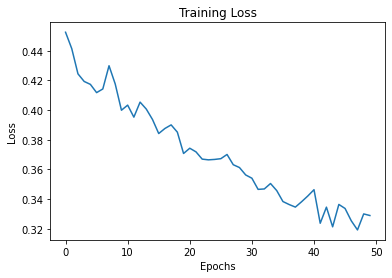

In [18]:
plt.plot(loss_array)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [19]:
def class_label(t):
  if t > 0.5:
    return 1.0
  else:
    return 0.0


In [20]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        X = X.to(DEVICE)  # sending data to GPU
        y = (torch.unsqueeze(y, 1).type(torch.float32)).to(DEVICE)  # sending data to GPU
        output = classifierNet(X)
        #print(output)
        for idx, i in enumerate(output):
            #print(class_label(i), y[idx])
            if class_label(i) == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy:  0.783


# Saving and Loading the mode

In [25]:
PATH = "/content/drive/Shareddrives/NMA_DL_Dolma_1/Models/ClassifierNet.pth"

torch.save(classifierNet, PATH)

In [ ]:
model = torch.load(PATH)